In [1]:
!pip install kagglehub tensorflow opencv-python matplotlib seaborn scikit-learn

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, random, warnings
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Dependencies loaded")
print(f"TensorFlow: {tf.__version__}, Keras: {keras.__version__}")


Dependencies loaded
TensorFlow: 2.19.0, Keras: 3.10.0


In [2]:
path = kagglehub.dataset_download("crawford/emnist")
print("Dataset path:", path)
for root, _, files in os.walk(path):
    for f in files:
        if f.endswith(".csv") and "digits" in f:
            print(os.path.join(root, f))


Dataset path: /kaggle/input/emnist
/kaggle/input/emnist/emnist-digits-train.csv
/kaggle/input/emnist/emnist-digits-test.csv


In [3]:
digits_train = next(
    os.path.join(r, f)
    for r, _, fs in os.walk(path)
    for f in fs
    if "digits" in f and "train" in f and f.endswith(".csv")
)
digits_test = next(
    os.path.join(r, f)
    for r, _, fs in os.walk(path)
    for f in fs
    if "digits" in f and "test" in f and f.endswith(".csv")
)

train_df = pd.read_csv(digits_train)
test_df  = pd.read_csv(digits_test)

print("Train shape:", train_df.shape)
print("Test shape: ", test_df.shape)


Train shape: (239999, 785)
Test shape:  (39999, 785)


Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]
Samples per class (train):
8
0    24000
1    24000
2    24000
3    24000
4    24000
5    24000
6    24000
7    24000
8    23999
9    24000
Name: count, dtype: int64


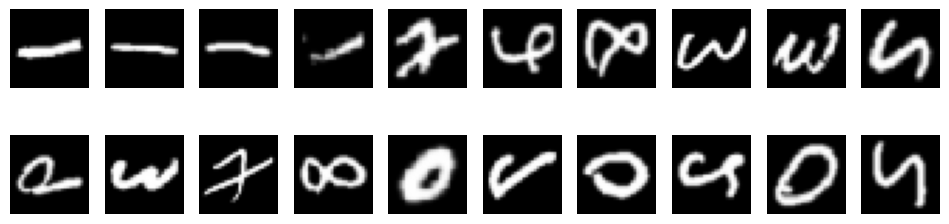

In [4]:
# Basic info
print("Classes:", sorted(train_df.iloc[:,0].unique()))
print("Samples per class (train):")
print(train_df.iloc[:,0].value_counts().sort_index())

# Display random samples
fig, axs = plt.subplots(2, 10, figsize=(12, 3))
for i, idx in enumerate(random.sample(range(len(train_df)), 20)):
    img = train_df.iloc[idx,1:].values.reshape(28,28)
    axs[i//10, i%10].imshow(img, cmap='gray')
    axs[i//10, i%10].axis('off')
plt.show()


In [5]:
# Split features/labels
X_train_raw = train_df.iloc[:,1:].values
y_train_raw = train_df.iloc[:,0].values
X_test_raw  = test_df.iloc[:,1:].values
y_test_raw  = test_df.iloc[:,0].values

# Reshape & normalize
X_train = X_train_raw.reshape(-1,28,28,1).astype('float32')/255.0
X_test  = X_test_raw.reshape(-1,28,28,1).astype('float32')/255.0
y_train = to_categorical(y_train_raw, 10)
y_test  = to_categorical(y_test_raw, 10)

# Validation split
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42, stratify=y_train
)

print("Shapes:", X_tr.shape, X_val.shape, X_test.shape)


Shapes: (203999, 28, 28, 1) (36000, 28, 28, 1) (39999, 28, 28, 1)


In [6]:
def create_model():
    model = keras.Sequential([
        layers.Conv2D(32,3, activation='relu', padding='same', input_shape=(28,28,1)),
        layers.BatchNormalization(), layers.MaxPooling2D(), layers.Dropout(0.25),
        layers.Conv2D(64,3, activation='relu', padding='same'),
        layers.BatchNormalization(), layers.MaxPooling2D(), layers.Dropout(0.25),
        layers.Conv2D(128,3, activation='relu', padding='same'),
        layers.BatchNormalization(), layers.Dropout(0.25),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(), layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(10, activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer=Adam(1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,441,290 (13.13 MB)

 Trainable params: 3,439,818 (13.12 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [9]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7),
    ModelCheckpoint('best_digit_model.h5', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    X_tr, y_tr,
    epochs=3, batch_size=128,
    validation_data=(X_val,y_val),
    callbacks=callbacks,
    verbose=1
)


Epoch 1/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step - accuracy: 0.9697 - loss: 0.1035

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 652s 409ms/step - accuracy: 0.9697 - loss: 0.1035 - val_accuracy: 0.9895 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 2/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.9877 - loss: 0.0434

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 691s 415ms/step - accuracy: 0.9877 - loss: 0.0434 - val_accuracy: 0.9928 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 3/3
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step - accuracy: 0.9898 - loss: 0.0360

1594/1594 ━━━━━━━━━━━━━━━━━━━━ 681s 414ms/step - accuracy: 0.9898 - loss: 0.0360 - val_accuracy: 0.9930 - val_loss: 0.0268 - learning_rate: 0.0010


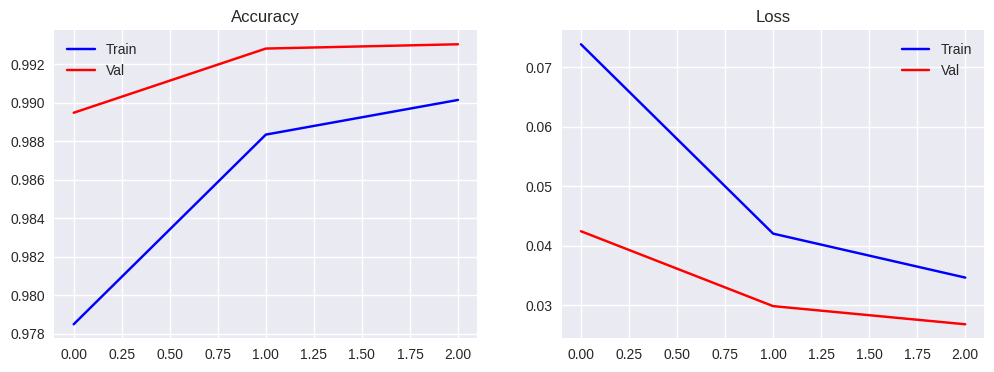

In [10]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'],'b-',label='Train')
plt.plot(history.history['val_accuracy'],'r-',label='Val')
plt.title("Accuracy"); plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'],'b-',label='Train')
plt.plot(history.history['val_loss'],'r-',label='Val')
plt.title("Loss"); plt.legend()
plt.show()


Test Accuracy: 0.9936, Loss: 0.0223
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 32s 26ms/step


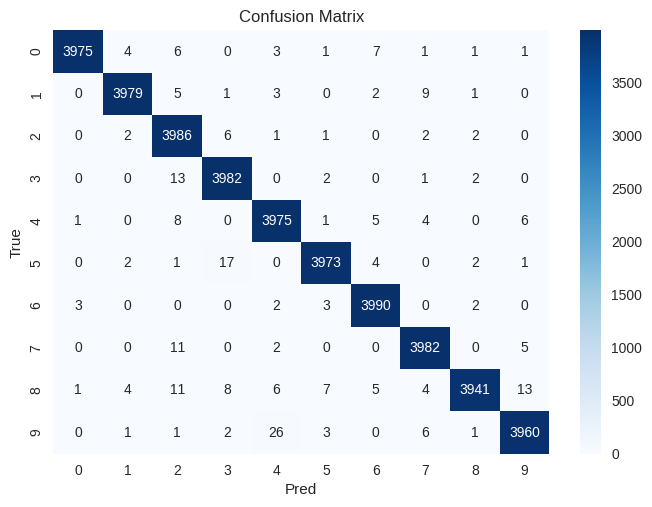

In [11]:
best_model = keras.models.load_model('best_digit_model.h5')
loss, acc = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}, Loss: {loss:.4f}")

# Confusion matrix
y_pred = np.argmax(best_model.predict(X_test),axis=1)
y_true = np.argmax(y_test,axis=1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix"); plt.xlabel("Pred"); plt.ylabel("True")
plt.show()


In [16]:
!pip install opencv-python tensorflow matplotlib pillow

import cv2, numpy as np, os, time, warnings
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output

warnings.filterwarnings('ignore')
print("🔧 Demo deps loaded:", cv2.__version__, tf.__version__)


🔧 Demo deps loaded: 4.12.0 2.19.0
